# Importing necessary libraries

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn import linear_model, decomposition, datasets
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import math
from mlxtend.plotting import plot_confusion_matrix

In [57]:
#retrieving the data
parkingdata = pd.read_csv("parking_duration_of_parking_event_vs_street_ID.csv")
# Choosing a random sample of 10000 data from the large data set for modelling
parkingdata = parkingdata.sample(n=10000)
parkingdata.size

130000

# Data Wrangling

In [58]:
#Converting all the feature attributes to uppercase for uniformity

parkingdata['Area Name'] = parkingdata['Area Name'].str.upper()
parkingdata['Street Name'] = parkingdata['Street Name'].str.upper()
parkingdata['Between Street 1'] = parkingdata['Between Street 1'].str.upper()
parkingdata['Between Street 2'] = parkingdata['Between Street 2'].str.upper()
parkingdata['Street Marker'] = parkingdata['Street Marker'].str.upper()
parkingdata['Sign'] = parkingdata['Sign'].str.upper()

parkingdata.head(5)

,Area Name,Street Name,Between Street 1,Between Street 2,Side Of Street,Street Marker,Arrival Time,Departure Time,Duration of Parking Event (in seconds),Sign,In Violation?,Street ID,Device ID
10788762,HYATT,FLINDERS STREET,RUSSELL STREET,EXHIBITION STREET,4,1613S,18/08/2012 08:58:21 AM,18/08/2012 10:36:44 AM,5903,2P TKT A M-SAT 7:30-20:30,0,670,5356
11535219,PRINCES THEATRE,SPRING STREET,LONSDALE STREET,LT BOURKE STREET,5,65W,10/09/2012 01:45:33 PM,10/09/2012 02:23:09 PM,2256,LZ 15M M-SUN 7:30-19:30,1,1288,6986
8287099,SOUTHBANK,FAWKNER STREET,SOUTHBANK BOULEVARD,FANNING STREET,2,8848E,04/06/2012 03:46:14 PM,04/06/2012 03:50:04 PM,230,P/ 10 M-SAT 7:30-19:30,0,656,4591
1004837,RIALTO,KING STREET,COLLINS STREET,FLINDERS LANE,2,1408E,28/10/2011 03:03:02 PM,28/10/2011 03:05:08 PM,126,2P MTR M-F 10:00-16:00,0,839,862
11260619,CHINATOWN,RUSSELL STREET,LONSDALE STREET,LT BOURKE STREET,1,C824,01/09/2012 02:33:55 PM,01/09/2012 03:16:54 PM,2579,1P MTR M-SAT 7:30-19:30,0,1221,4932


In [59]:
#Removing all redundant extra whitespaces
for x in parkingdata.columns:
    if parkingdata[x].dtype == object:
        parkingdata[x] = parkingdata[x].str.strip()

In [60]:
#converting object to datetime
parkingdata['Arrival Time'] = pd.to_datetime(parkingdata['Arrival Time'])
parkingdata['Departure Time'] = pd.to_datetime(parkingdata['Departure Time'])

In [61]:
#check which columns have missing values
parkingdata.columns[parkingdata.isnull().any()]

Index([], dtype='object')

# Target field identification and feature engineering

In [62]:
#Target field identification
duration = parkingdata['Duration of Parking Event (in seconds)'].copy()

print('Minimum parking duration (seconds): ' + str(duration.min()))
print('Maximum parking duration (seconds): ' + str(duration.max()))
print('\nMinimum parking duration (hour): ' + str(duration.min()/3600))
print('Maximum parking duration (hour): ' + str(duration.max()/3600))
print('\nMinimum parking duration is under [' + str(math.trunc(duration.min()/3600) + 1) + '] hours')
print('Maximum parking duration is under [' + str(math.trunc(duration.max()/3600) + 1) + '] hours')

durList = []
static = 1
df = pd.DataFrame()

for record in duration.values:
    hour = 3600
    index = 0
    while static == 1:
        if record < hour:
#             print("\nDuration in seconds: " + str(record))
            data = math.trunc(record/3600) + 1
            durList.append(data)
#             print("Duration is under " + str(data) + " hours")
            break
        else:
            hour += 3600

df.insert(0, 'Duration (Hours)', durList, True)
target = df['Duration (Hours)']
target.head(10)

Minimum parking duration (seconds): 6
Maximum parking duration (seconds): 46793

Minimum parking duration (hour): 0.0016666666666666668
Maximum parking duration (hour): 12.998055555555556

Minimum parking duration is under [1] hours
Maximum parking duration is under [13] hours


0    2
1    1
2    1
3    1
4    1
5    1
6    1
7    2
8    1
9    2
Name: Duration (Hours), dtype: int64

In [63]:
#Preliminary Target Features identification (Pre-Hill Climbing)

#Convert possible targets to dtype = int
intDf = parkingdata.copy()
#Drop useless fields
intDf.drop('Arrival Time', axis = 1, inplace = True)
intDf.drop('Departure Time', axis = 1, inplace = True)
intDf.drop('Street Marker', axis = 1, inplace = True)
#Drop target field
intDf.drop('Duration of Parking Event (in seconds)', axis = 1, inplace = True)
#Drop already int fields (Will add back after)
intDf.drop('In Violation?', axis = 1, inplace = True)
intDf.drop('Side Of Street', axis = 1, inplace = True)
intDf.drop('Street ID', axis = 1, inplace = True)
intDf.drop('Device ID', axis = 1, inplace = True)

#Transform the remainder non-int fields' values to unique int identifiers
for column in intDf:
    unique_vals = intDf[column].unique()
    intDf[column].replace(to_replace = unique_vals, value = list(range(len(unique_vals))), inplace = True)

#Create dataframe for all the relevant features
features = intDf.copy()

#Add back int fields (If not the target field)
features['In Violation?'] = parkingdata['In Violation?']
features['Side Of Street'] = parkingdata['Side Of Street']
features['Street ID'] = parkingdata['Street ID']
features['Device ID'] = parkingdata['Device ID']
#Add back datetime features with only the meaningful subset of data
features['Arrival Hour'] = parkingdata['Arrival Time'].dt.hour
features['Departure Hour'] = parkingdata['Departure Time'].dt.hour

#Table view of features dataframe
features.head(10)

,Area Name,Street Name,Between Street 1,Between Street 2,Sign,In Violation?,Side Of Street,Street ID,Device ID,Arrival Hour,Departure Hour
10788762,0,0,0,0,0,0,4,670,5356,8,10
11535219,1,1,1,1,1,1,5,1288,6986,13,14
8287099,2,2,2,2,2,0,2,656,4591,15,15
1004837,3,3,3,3,3,0,2,839,862,15,15
11260619,4,4,1,1,4,0,1,1221,4932,14,15
7350910,5,4,4,4,5,0,5,1221,512,13,13
11162043,6,5,5,5,4,0,4,528,1325,17,18
6072565,1,6,6,6,5,1,3,907,1319,18,19
9725413,7,7,7,7,6,0,3,856,4900,14,14
4645535,2,8,8,8,7,1,3,597,4770,10,11


# Parameter tuning and Random Forest data modelling

In [64]:
#Parameter Tuning

#Define the parameters to tune and the values to tune to
params_randomforest = [
                { 
                   'n_estimators' : (10,20,30,50,70,90,100),
                    'criterion' : ('gini', 'entropy'),
                    'max_depth' : (3, 5, 7, 9, 10, 15),
                    'max_features' : ('auto', 'sqrt'),
                    'min_samples_split' : (2, 4, 6, 8, 10, 14, 16)
                    
                }
            ]

In [65]:
cv_method = RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats = 1, 
                                    random_state = 1)

gs_randomforest = GridSearchCV(RandomForestClassifier(), 
                      param_grid = params_randomforest, 
                      cv = cv_method,
                      verbose = True,
                      scoring = 'accuracy',
                      n_jobs = -1,
                      return_train_score = True)

In [66]:
#Fit the model with the dataset
bestModel = gs_randomforest.fit(features, target)

Fitting 5 folds for each of 1176 candidates, totalling 5880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 5880 out of 5880 | elapsed:  5.1min finished


In [67]:
gs_randomforest.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_split': 4,
 'n_estimators': 70}

In [68]:
#Find the best values for the  parameters of the model (Formatted output)
best_e = bestModel.best_estimator_.get_params()['n_estimators']
best_C = bestModel.best_estimator_.get_params()['criterion']
best_maxd =  bestModel.best_estimator_.get_params()['max_depth']
best_maxf =  bestModel.best_estimator_.get_params()['max_features']
best_mins =  bestModel.best_estimator_.get_params()['min_samples_split']

print('Best estimator:', best_e)
print('Best criterion:', best_C)
print('Best max depth:', best_maxd)
print('Best max features:', best_maxf)
print('Best min_samples_split:', best_mins)

Best estimator: 70
Best criterion: entropy
Best max depth: 15
Best max features: auto
Best min_samples_split: 4


In [69]:
#Visualise the parameter configurations from fitting the model with the dataset
results_randomforest = pd.DataFrame(gs_randomforest.cv_results_['params'])
results_randomforest['test_score'] = gs_randomforest.cv_results_['mean_test_score']
results_randomforest

,criterion,max_depth,max_features,min_samples_split,n_estimators,test_score
0,gini,3,auto,2,10,0.8188
1,gini,3,auto,2,20,0.8163
2,gini,3,auto,2,30,0.8122
3,gini,3,auto,2,50,0.8133
4,gini,3,auto,2,70,0.8180
...,...,...,...,...,...,...
1171,entropy,15,sqrt,16,30,0.8594
1172,entropy,15,sqrt,16,50,0.8605
1173,entropy,15,sqrt,16,70,0.8609
1174,entropy,15,sqrt,16,90,0.8615


In [70]:
#Re-Define model with the optimal parameter values AFTER HILL CLIMBING
randomforest = metric = RandomForestClassifier(n_estimators = best_e, 
                               criterion = best_C, 
                               max_depth = best_maxd, 
                               max_features = best_maxf,
                               min_samples_split = best_mins                
                               )

In [71]:
# Hill climbing w/ Randomforest
new_Ind = []
cur_MaxScore = 0.0
col_num = len(features.columns)
col_Ind_Random = shuffle(range(0, col_num), random_state = 1)
features_array = features.values

for cur_f in range(col_num):
    new_Ind.append(col_Ind_Random[cur_f])
    newData = features_array[:, new_Ind]
    x_train, x_test, y_train, y_test = train_test_split(newData, target, test_size=0.2, random_state=1)
    fit = randomforest.fit(x_train, y_train)
    cur_Score = randomforest.score(x_test, y_test)
    
    if cur_Score < cur_MaxScore:
        new_Ind.remove(col_Ind_Random[cur_f])
    else:
        cur_MaxScore = cur_Score
        print ("Score with " + str(len(new_Ind)) + " selected features: " + str(cur_Score))
print("\nIndexs of the desired features")
print(new_Ind)

Score with 1 selected features: 0.7805
Score with 2 selected features: 0.781
Score with 3 selected features: 0.8165

Indexs of the desired features
[2, 1, 5]


In [72]:
features_hc = pd.DataFrame()
for index in new_Ind:
    colName = features.columns[index]
    features_hc[colName] = features[colName]
features_hc.head(10)

,Between Street 1,Street Name,In Violation?
10788762,0,0,0
11535219,1,1,1
8287099,2,2,0
1004837,3,3,0
11260619,1,4,0
7350910,4,4,0
11162043,5,5,0
6072565,6,6,1
9725413,7,7,0
4645535,8,8,1


In [73]:
bestModel = gs_randomforest.fit(features_hc, target)

Fitting 5 folds for each of 1176 candidates, totalling 5880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 2342 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2892 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3542 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4292 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 5142 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 5880 out of 5880 | elapsed:  3.1min finished


In [74]:
gs_randomforest.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_split': 4,
 'n_estimators': 90}

In [75]:
best_e_hc = bestModel.best_estimator_.get_params()['n_estimators']
best_C_hc = bestModel.best_estimator_.get_params()['criterion']
best_maxd_hc =  bestModel.best_estimator_.get_params()['max_depth']
best_maxf_hc =  bestModel.best_estimator_.get_params()['max_features']
best_mins_hc =  bestModel.best_estimator_.get_params()['min_samples_split']

print('Best estimators:', best_e_hc)
print('Best criterion:', best_C_hc)
print('Best max depth:', best_maxd_hc)
print('Best max features:', best_maxf_hc)
print('Best min_samples_split:', best_mins_hc)

Best estimators: 90
Best criterion: gini
Best max depth: 10
Best max features: auto
Best min_samples_split: 4


In [76]:
#Visualise the parameter configurations from fitting the model with the dataset
results_randomforest = pd.DataFrame(gs_randomforest.cv_results_['params'])
results_randomforest['test_score'] = gs_randomforest.cv_results_['mean_test_score']
results_randomforest

,criterion,max_depth,max_features,min_samples_split,n_estimators,test_score
0,gini,3,auto,2,10,0.8090
1,gini,3,auto,2,20,0.8078
2,gini,3,auto,2,30,0.8049
3,gini,3,auto,2,50,0.8076
4,gini,3,auto,2,70,0.8083
...,...,...,...,...,...,...
1171,entropy,15,sqrt,16,30,0.8360
1172,entropy,15,sqrt,16,50,0.8370
1173,entropy,15,sqrt,16,70,0.8380
1174,entropy,15,sqrt,16,90,0.8372


In [77]:
randomforest = metric = RandomForestClassifier(n_estimators = best_e_hc, 
                               criterion = best_C_hc, 
                               max_depth = best_maxd_hc, 
                               max_features = best_maxf_hc,
                               min_samples_split = best_mins_hc                
                               )

# Classification Report

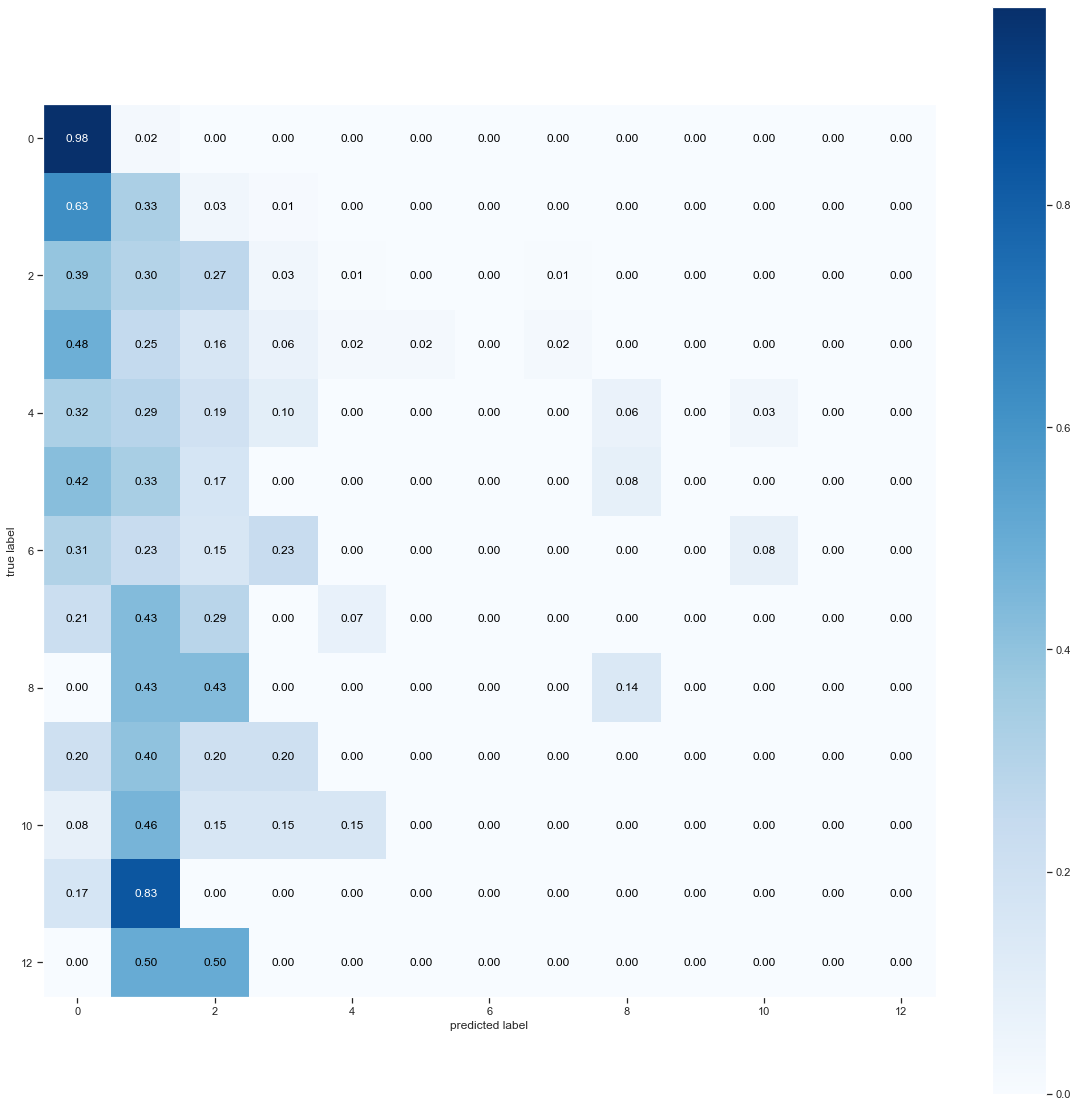


 Accuracy score: 0.83740


In [78]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
randomforest.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = randomforest.predict(x_test)
cm = metrics.confusion_matrix(y_test,predicted)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                               figsize=(20, 20))
plt.show()

print("\n Accuracy score: {:.5f}".format(randomforest.score(x_test, y_test)))

In [79]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           1       0.88      0.98      0.93      4010
           2       0.54      0.33      0.41       661
           3       0.43      0.27      0.33       160
           4       0.15      0.06      0.09        64
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00        13
           8       0.00      0.00      0.00        14
           9       0.20      0.14      0.17         7
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00        13
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         4

    accuracy                           0.84      5000
   macro avg       0.17      0.14      0.15      5000
weighted avg       0.79      0.84      0.81      5000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# K-folds mean score

In [80]:
#Repeat with KFold - creating groups
kf = KFold(n_splits = 5, random_state = 4, shuffle = True)


#Repeat with KFold - Training model (previously defined) and obtaining its output
kFoldTotal = 0
for k, (train_index, test_index) in enumerate(kf.split(features_hc)):
    x_train, x_test = features_hc.iloc[train_index], features_hc.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    randomforest.fit(x_train, y_train)
    kFoldTotal += randomforest.score(x_test, y_test)
    print("[fold {0}] score: {1:.5f}".format(k, randomforest.score(x_test, y_test)))

#Printing out the results
roundedTotal = round(kFoldTotal/5, 5)
print("\nRandom Forest mean score [5 folds] = " + str(roundedTotal))

[fold 0] score: 0.85050
[fold 1] score: 0.83350
[fold 2] score: 0.85200
[fold 3] score: 0.82450
[fold 4] score: 0.83850

Random Forest mean score [5 folds] = 0.8398
